# Прогнозирование дефолтов по кредитам
### Итоговый проект по курсу Библиотеки Python для Data Science

### Содержание <a name = 'outline'></a>
* I. [Построение модели классификации](#EDA_and_model)
* [1. Обзор обучающего датасета](#data) 
* [2. Загрузка данных](#load_data) 
* [3. Анализ целевой переменной](#target_variable)
* [4. Создание групп для Weight of Evidence (WOE) ](#WOE)
* [5. Feature Engineering](#feature_engineering)
* [6. Tain_test_split](#tain_test_split)
* [7. Генерация признаков](#feature_generation)
* [8. Балансировка классов](#class_balancing)
* [9. Отбор признаков](#feature_selection)
* [10. Модель](#model)
* [11. Интерпретация результатов](#results_interpretation)


* II. [Прогнозирование на тестовом датасете](#forecasting)

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as ss

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score, brier_score_loss

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## I. Построение модели классификации <a name = 'EDA_and_model'></a>

### 1. Обзор обучающего датасета <a name = 'data'></a>

#### Описание датасета

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Пути к директориям и файлам

In [3]:
PATH = 'C:/Users/ASER/Desktop/GeekBrains/ML_project/'
TRAIN_DATASET_PATH = PATH + 'course_project_train.csv'
TEST_DATASET_PATH = PATH + 'course_project_test.csv'
PREP_DATASET_PATH = PATH + 'course_project_prep_train.csv'

### 2. Загрузка данных <a name = 'load_data'></a>

In [4]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1


In [5]:
X_final = pd.read_csv(TEST_DATASET_PATH)
print('X_final.shape', X_final.shape)
X_final.head(2)

X_final.shape (2500, 16)


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0


In [6]:
TARGET_NAME = 'Credit Default'
X = df.drop(TARGET_NAME, axis=1)
y = df[TARGET_NAME]
print('X.shape = ', X.shape)
print('y.shape = ', y.shape)

X.shape =  (7500, 16)
y.shape =  (7500,)


In [7]:
NUMERIC_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
                         'Maximum Open Credit', 'Number of Credit Problems', 
                         'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
                         'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CATEGORICAL_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Purpose', 'Term']
NEW_NUMERIC_FEATURE_NAMES = []

### Пропуски данных

In [8]:
len(df) - df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Пропуски данных рассматриваем как отдельную категорию и заполнять не будем.

[назад к содержанию](#outline)

### 3. Анализ целевой переменной <a name = 'target_variable'></a>

### 3.1 Обзор распределения

In [9]:
y.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

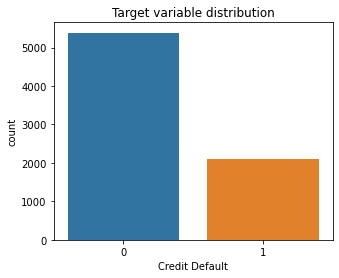

In [10]:
plt.figure(figsize=(5, 4))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

### 3.2 Оценка признаков в в разрезе целевой переменной

### A. Количественные признаки

**Корреляция с базовыми признаками**

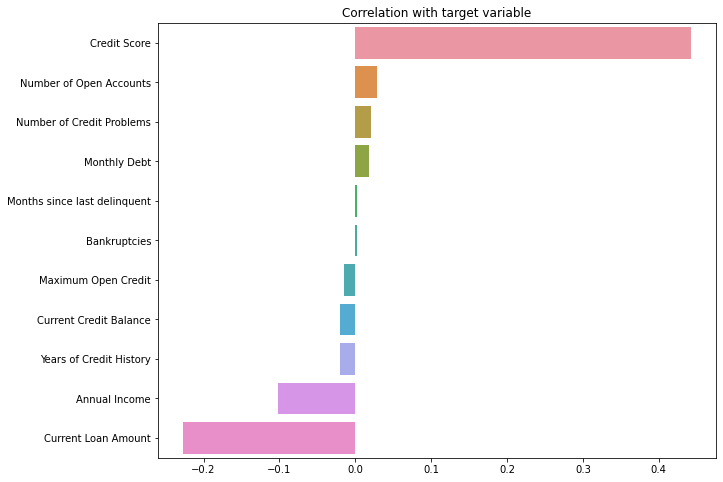

In [11]:
corr_with_target = df[NUMERIC_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [12]:
def var_target_plot(var_name, t1=None, t2=None):
    var_target_0 = df.loc[df[TARGET_NAME] == 0, var_name]
    var_target_1 = df.loc[df[TARGET_NAME] == 1, var_name]
    
    if not (t1 and t2):    
        t1 = min(df[var_name])
        t2 = max(df[var_name])
    else:
        t1 = min(df.loc[(df[var_name] >= t1) & (df[var_name] <= t2), var_name])
        t2 = max(df.loc[(df[var_name] >= t1) & (df[var_name] <= t2), var_name])
    print(f'min: {t1}, max: {t2}')
    if t1 == t2:
        t1 -= 1

    bins = np.linspace(t1, t2, 50)
    plt.figure(figsize=(8,4))
    plt.hist(var_target_0, bins, density=True, alpha=0.5, label='No default')
    plt.hist(var_target_1, bins, density=True, alpha=0.5, label='Default')
    plt.legend(bbox_to_anchor=(1.2,1), loc='upper right')
    plt.show()
    
    
def distribution_diff(var_name):
    var_target_0 = df.loc[df[TARGET_NAME] == 0, var_name].value_counts(normalize=True)
    var_target_1 = df.loc[df[TARGET_NAME] == 1, var_name].value_counts(normalize=True)
    return var_target_0 - var_target_1

In [13]:
def chi2_test(var_name, a):
    f = df[[var_name, TARGET_NAME]].copy()
    for i in range(1, len(a)):     
        f.loc[(f[var_name] >= a[i - 1]) & (f[var_name] < a[i]), 'group'] = i    

    for i in range(1, len(a)-1):       
        p_list = []
        for _ in range(20):
            var_and_target = f.loc[f['group'].isin([i, i + 1]), ['group', var_name, TARGET_NAME]]
            if var_and_target.shape[0] < 1000:
                var_and_target_s = var_and_target
            else:
                var_and_target_s = var_and_target.sample(1000)
            
            table = var_and_target_s.pivot_table(values=var_name, index='group', columns=TARGET_NAME, aggfunc='count')
            chi2, p, dof, expected = ss.chi2_contingency(table, correction=False)
            
            p_list.append(p)
        print(f'p = {round(np.array(p_list).mean(),2)} \t{a[i]} - {a[i+1]}')

#### 1. Credit Score

min: 585.0, max: 7510.0


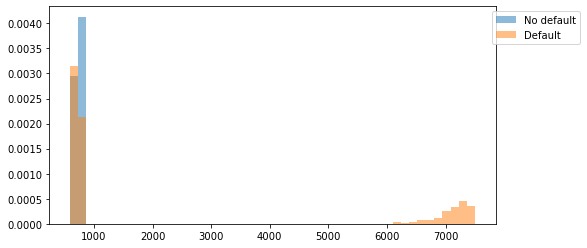

In [14]:
var_name = 'Credit Score'
var_target_plot(var_name)

Признак Credit Score анализируем в двух диапазонах 580-1000 и 1000-7510

min: 585.0, max: 751.0


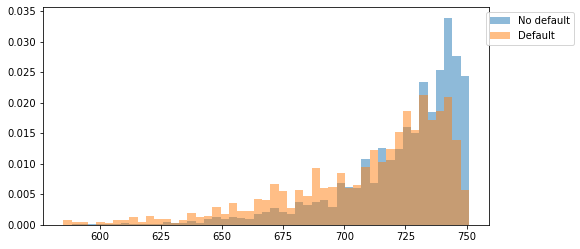

In [15]:
var_target_plot(var_name, 585, 1000)

* При Credit Score до 710 наблюдается высокая плотность дефолтов
* При Credit Score 710 - 730 уровень дефолтов снижается
* В диапазоне Credit Score 730-742 ситуация преломляется в пользу бездефолтных кредитов 
* В диапазоне Credit Score 742-754 уровень дефолтов самый низкий 

min: 6060.0, max: 7510.0


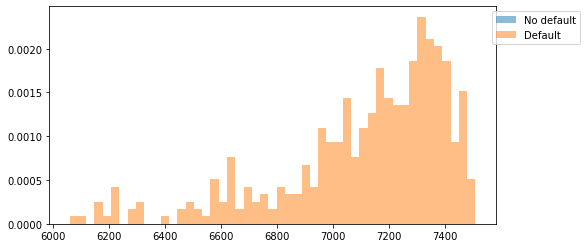

In [16]:
var_target_plot(var_name, 1000, 7510)

При значениях Credit Score выше 6000 целевая переменная равна 1 (100% дефолт). Выделим их в отдельный признак Default Credit Score

#### 2. Current Loan Amount

min: 11242.0, max: 99999999.0


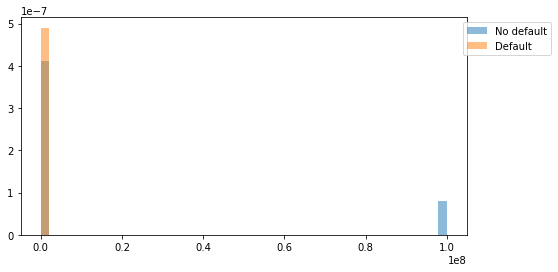

In [17]:
var_name = 'Current Loan Amount'
var_target_plot(var_name)

Признак Current Loan Amount нужно анализировать в двух диапазонах до 1 млн. и выше 1 млн.

min: 11242.0, max: 789030.0


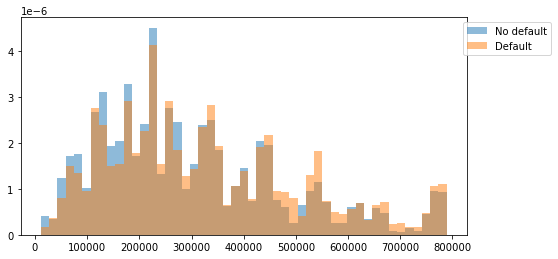

In [18]:
var_target_plot(var_name,  11242.0, 1e+06)

В диапазоне до 790 тыс неблюдается следующая картина:
* Самый низкий уровень дефолтов при значении Current Loan Amount до 250 тыс.
* Средний уровень при значении признака 250-500 тыс.
* Самый высокий уровень дефолтов в диапазоне 500-800тыс.

min: 99999999.0, max: 99999999.0


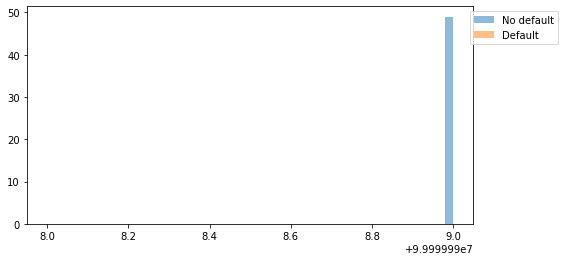

In [19]:
var_target_plot('Current Loan Amount', 1e+06, 99999999)

В диапазоне выше 1 млн. есть единственное значение Current Loan Amount: 99999999. Оно соответствует полному отсутствию дефолтов. Выделим для всех этих значений отдельный признак No Defaults

#### 3. Annual Income

min: 164597.0, max: 10149344.0


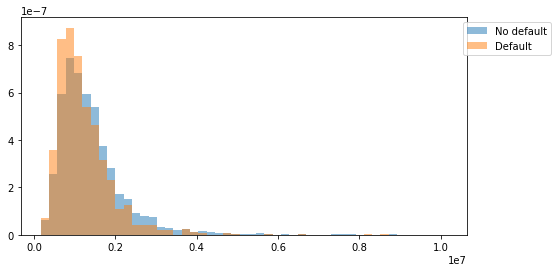

In [20]:
var_name = 'Annual Income'
var_target_plot(var_name)

Рассмотрим 2 диапазона Annual Income: до 3 млн. и выше 3 млн.

min: 164597.0, max: 2997497.0


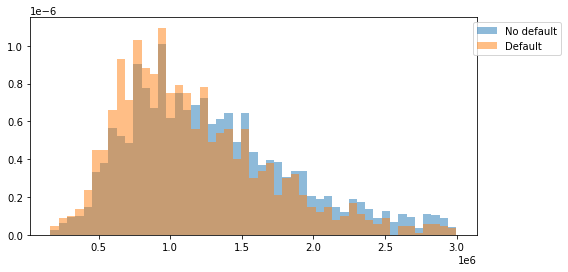

In [21]:
var_target_plot(var_name,  164597, 3e+06)

* При Annual Income до 1.1 млн наблюдается самая высокая вероятность дефолта
* В диапазоне 1.1-3 млн. вероятность дефолта заметно снижается.

min: 3009201.0, max: 10149344.0


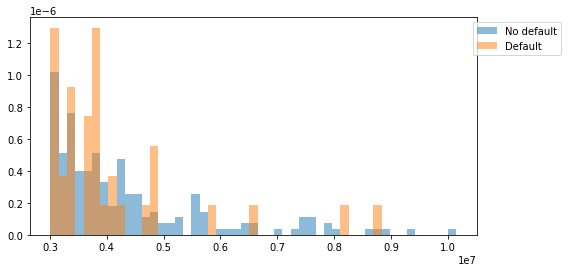

In [22]:
var_target_plot(var_name,  3e+06, 10149344)

Далее выделяются диапазоны 3-5 млн. и выше 5 млн

#### 4. Number of Open Accounts

min: 2.0, max: 43.0


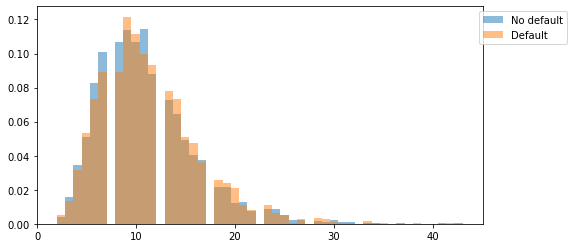

In [23]:
var_target_plot('Number of Open Accounts')

* При Number of Open Accounts до 8 включительно, наблюдается самый низкий уровень дефолтов
* В диапазоне 9-12 ситуация ухудшается
* При Number of Open Accounts выше 12 уровеньь дефолтов самый высокий 

#### 5. Monthly Debt

min: 0.0, max: 136679.0


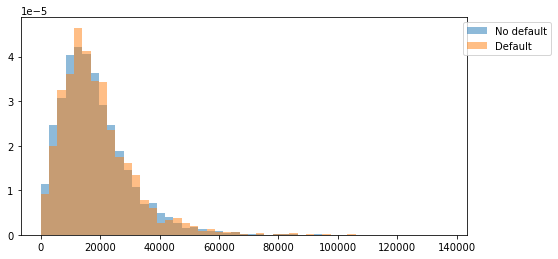

In [24]:
var_target_plot('Monthly Debt')

* При Monthly Debt ниже 6 тыс. уровень дефолтов самый низкий
* Далее ситуация постепенно ухудшается в диапазонах 6-10, выше 10 тыс.

Рассмотрим покрытие ежемесячного долга годовым доходом. 

#### Monthly Debt cover

Для расчета возьмем знаения Annual Income меньше 3 млн.

In [25]:
var_name = 'Monthly Debt cover'
cond_1 = (df['Annual Income'] < 3e+06) & (df['Monthly Debt'] > 0)
df.loc[:, var_name] = df.loc[cond_1, 'Annual Income'] / df.loc[cond_1, 'Monthly Debt']

min: 30.074508653564095, max: 17124.0


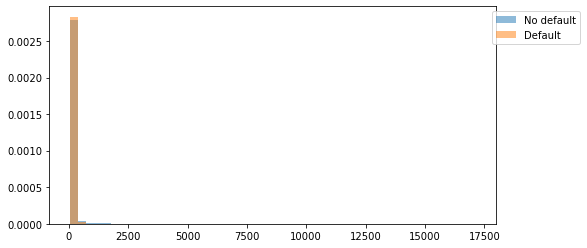

In [26]:
var_target_plot(var_name)

Рассмотрим 2 диапазона до 300 и свыше 300 раз.

min: 30.074508653564095, max: 299.9727420667209


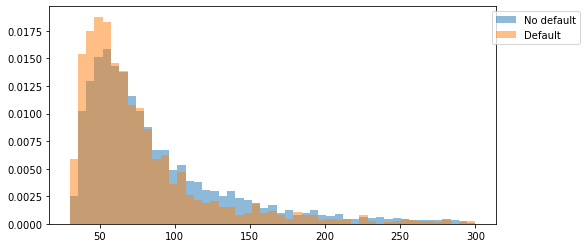

In [27]:
var_target_plot(var_name, 30, 300)

min: 300.70588235294116, max: 17124.0


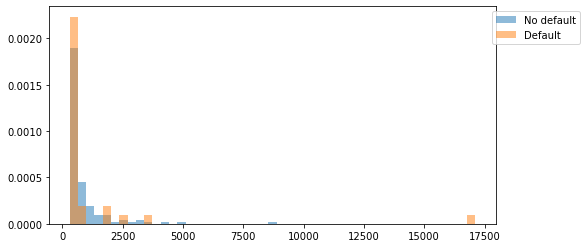

In [28]:
var_target_plot(var_name, 300, 17125)

Самый высокий урровень дефолтов при покрытии ежемесячных платежей годовым доходом до 55 раз. Потом уровень дефолтов постепенно снижается в диапазонах 30-55, 55-75, 75-150, 150-300, выше 300.

Включаем новый признак в список признаков.

In [29]:
NEW_NUMERIC_FEATURE_NAMES.append(var_name)

#### 6. Years of Credit History

min: 4.0, max: 57.7


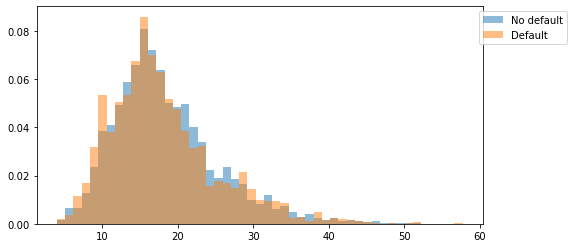

In [30]:
var_name = 'Years of Credit History'
var_target_plot(var_name)

* Самый высокий уровень дефолтов наблюдается при Years of Credit History до 10
* Далее он постепенно снижается в диапазонах 10-13, выше 13-28, а после 28 снова возрастает

#### 7. Current Credit Balance

min: 0.0, max: 6506797.0


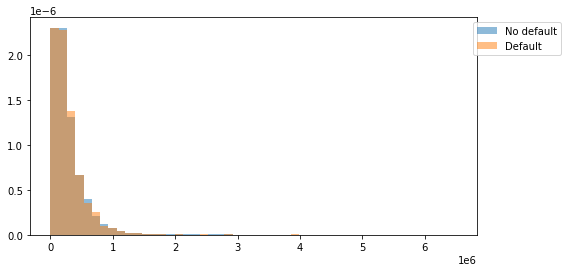

In [31]:
var_name = 'Current Credit Balance'
var_target_plot(var_name)

Рассмотрим диапазоны Current Credit Balance до 500 тыс и выше

min: 19.0, max: 499852.0


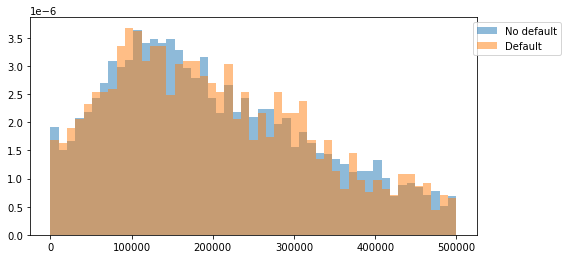

In [32]:
var_target_plot(var_name, 0.1, 5e+05)

* В диапазоне  до 500 тыс Current Credit Balance ведет себя нестабильно, какие-то тенденции заметит сложно.
* Нужно проанализировать, поможет ли укрупннение диапазонов до 110 тыс, 110-170, 170-320, 320-500 тыс, выявлению какой-то функциональной зависимости.

min: 500232.0, max: 6506797.0


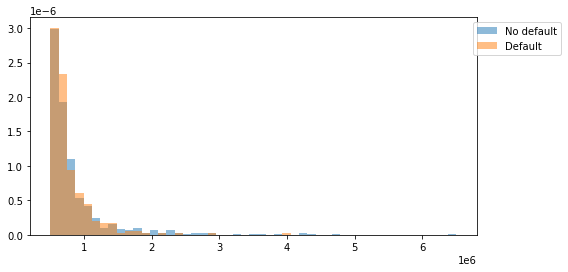

In [33]:
var_target_plot(var_name, 5e+05, 6506797)

* Диапазон выше 500 тыс. также нужно анализировать дополнительно
* Сгруппируем все частоты в один список и проведем chi2_contingency тесты для каждого диапазона, начиная с 0

In [34]:
a = [0, 1.1e+05, 1.7e+05, 3.2e+05, 5e+05, 6.6e+06]
chi2_test(var_name, a)

p = 0.45 	110000.0 - 170000.0
p = 0.4 	170000.0 - 320000.0
p = 0.44 	320000.0 - 500000.0
p = 0.65 	500000.0 - 6600000.0


У всех диапазонов p-value существенно выше 0.05, разбить признак на группы не получится, использовать его в модели не будем.

In [35]:
NUMERIC_FEATURE_NAMES.remove(var_name)

Из признаков Current Credit Balance и Monthly Debt логично сгенерировать признак Months till repayment, который бы учитывал месяцы до выплаты кредита. Он должен быть более информативным по сравнению с Current Credit Balance

#### Months till Credit Balance repayment

In [36]:
var_name = 'Months till Credit Balance repayment'
df.loc[:, var_name] = df['Current Credit Balance'] / df['Monthly Debt']

min: 0.0, max: 502.3074753173484


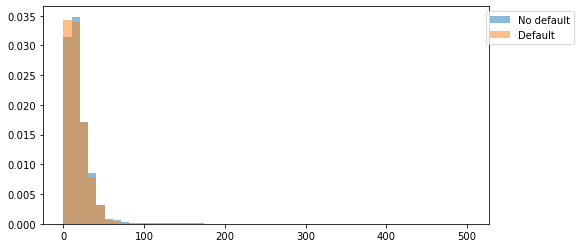

In [37]:
var_target_plot(var_name)

Рассмотрим два диапазона до 67 месяцев и выше 

min: 0.10905520731062608, max: 66.95664467483506


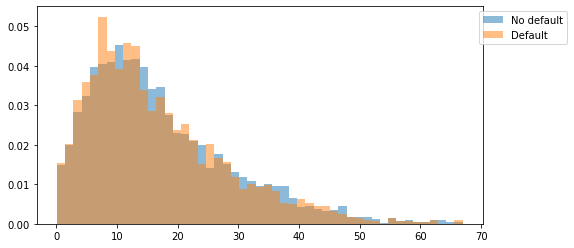

In [38]:
var_target_plot(var_name, 0.1, 67)

min: 67.01514969339907, max: 502.3074753173484


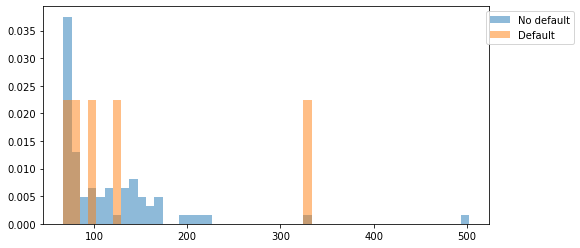

In [39]:
var_target_plot(var_name, 67, 503)

Самый высокий риск дефолта в диапазоне до 12 месяцев. Потом он постепенно снижается в диапазонах 12-36, 36-67 и свыше 67 месяцев. Включаем новую переменную в список переменных.

In [40]:
NEW_NUMERIC_FEATURE_NAMES.append(var_name)

#### 8. Maximum Open Credit

min: 0.0, max: 1304726170.0


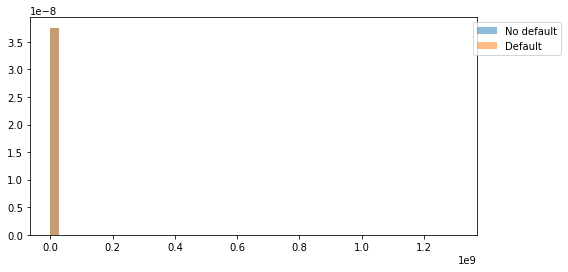

In [41]:
var_name = 'Maximum Open Credit'
var_target_plot(var_name)

Рассмотрим 2 диапазона Maximum Open Credit: до 7 млн и выше

min: 4334.0, max: 6890070.0


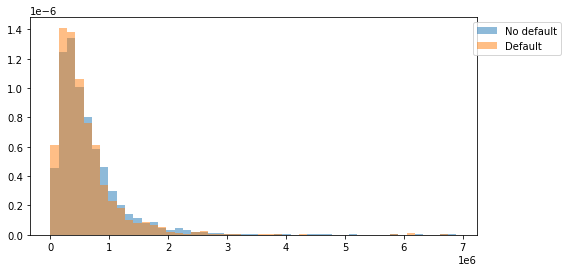

In [42]:
var_target_plot(var_name, 0.1, 7e+06)

Отдельно рассмотрим диапазон до 600 тыс.

min: 4334.0, max: 599984.0


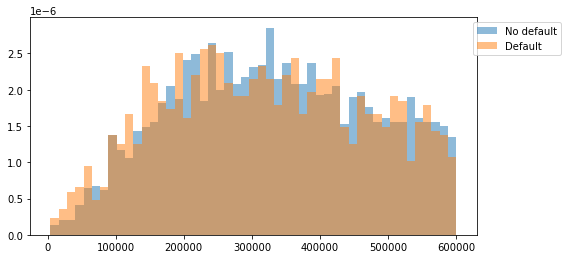

In [43]:
var_target_plot(var_name, 0.1, 6e+05)

* Самый высокий уровень дефолтов наблюдается при Maximum Open Credit до 170 тыс.
* В диапазонах 170-600, 600-800 тыс., 800 тыс.-7 млн. уровень дефолтов постепенно снижается

min: 7204516.0, max: 1304726170.0


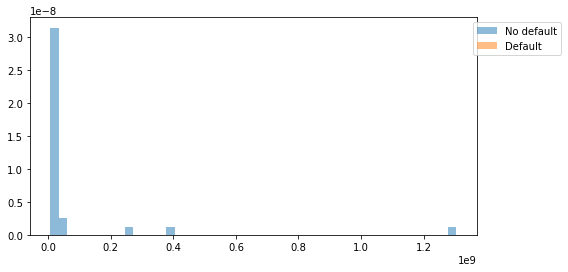

In [44]:
var_target_plot(var_name, 7e+06, 1304726170)

В диапазоне выше 7 млн. дефолтов не наблюдается

#### 9. Months since last delinquent

min: 1.0, max: 92.0


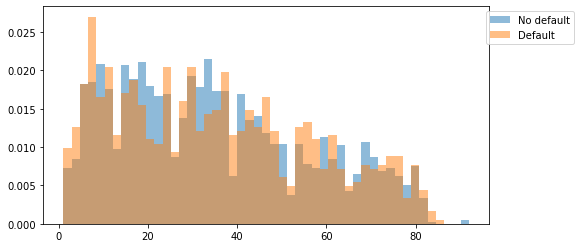

In [45]:
var_name = 'Months since last delinquent'
var_target_plot(var_name, 0.1, 100)

Разобъем Months since last delinquent на 2 диапазона: до 36 и после.

min: 1.0, max: 36.0


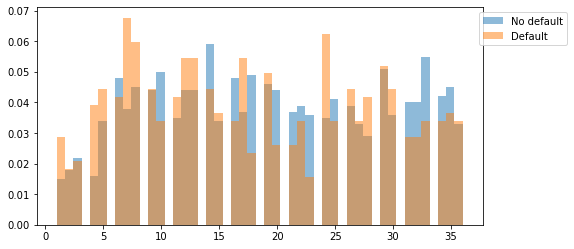

In [46]:
var_target_plot(var_name, 1, 36)

* Уровень дефолтов Months since last delinquent до 13 месяцев выше чем в диапазоне 13-24.
* В диапазоне 25-30 наблюдается рост дефолтов, а в 31-36 - снижение.

min: 36.0, max: 92.0


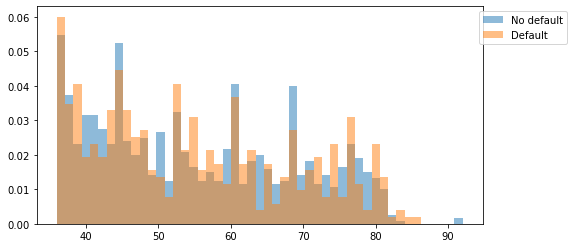

In [47]:
var_target_plot(var_name, 36, 92)

* После 36 месяцев уровень дефолтов немного снижается.

In [48]:
a = [0, 13, 25, 31, 36, 100]
chi2_test(var_name, a)

p = 0.04 	13 - 25
p = 0.21 	25 - 31
p = 0.03 	31 - 36
p = 0.06 	36 - 100


В целом, p-value достаточно небольшие, с учетом большого числа пропусков у признака Months since last delinquent, можно остановиться на таком разделении.

#### 10. Number of Credit Problems

min: 0.0, max: 7.0


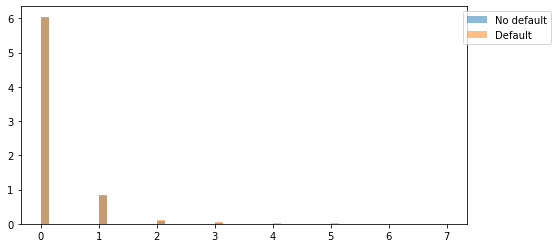

In [49]:
var_name = 'Number of Credit Problems'
var_target_plot(var_name)

In [50]:
distribution_diff(var_name)

0.0    0.004963
1.0    0.004934
2.0   -0.004480
3.0   -0.002727
4.0   -0.002283
5.0   -0.001336
6.0         NaN
7.0         NaN
Name: Number of Credit Problems, dtype: float64

Зависимости дефолтов от изменения уровней Number of Credit Problems не наблюдается. Признак не будет задействован в модели

In [51]:
NUMERIC_FEATURE_NAMES.remove(var_name)

#### 11. Bankruptcies

min: 0.0, max: 4.0


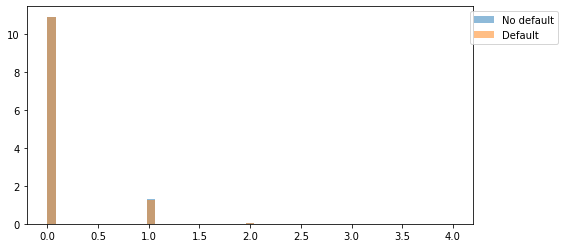

In [52]:
var_name = 'Bankruptcies'
var_target_plot(var_name)

In [53]:
distribution_diff(var_name)

0.0   -0.001126
1.0    0.002929
2.0   -0.001496
3.0   -0.000018
4.0   -0.000288
Name: Bankruptcies, dtype: float64

Зависимости дефолтов от изменения уровней Bankruptcies не наблюдается. Признак не будет задействован в модели

In [54]:
NUMERIC_FEATURE_NAMES.remove(var_name)

#### Анализ признакового пространства

**Матрица корреляций**

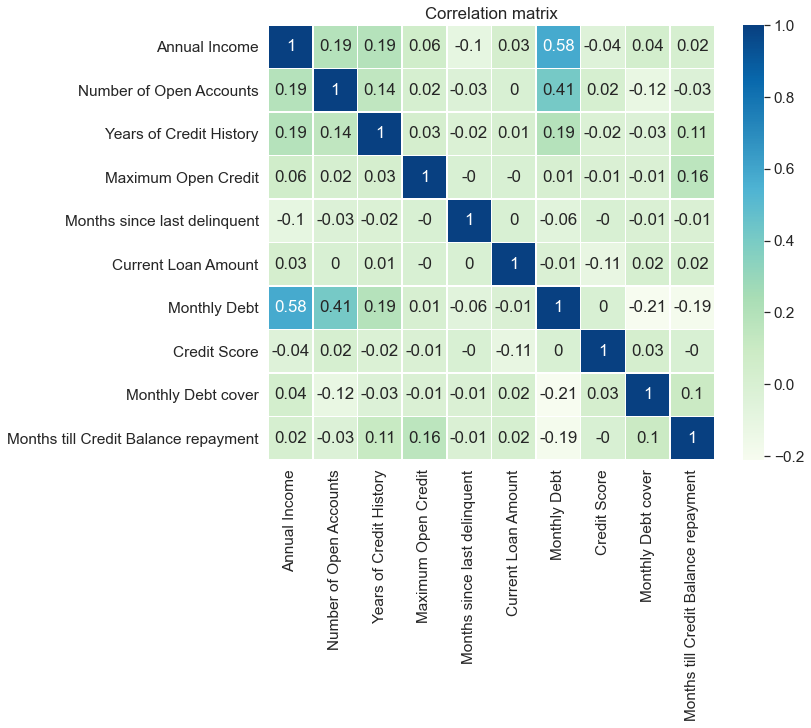

In [55]:
plt.figure(figsize = (10, 8))

sns.set(font_scale=1.4)
sns.heatmap(df[NUMERIC_FEATURE_NAMES + NEW_NUMERIC_FEATURE_NAMES].corr().round(2), 
            annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

[назад к содержанию](#outline)

### B. Категориальные признаки

In [56]:
def category_var_target_plot(var_name, t1, t2):
    var_target_0 = df.loc[df[TARGET_NAME] == 0, var_name]
    var_target_1 = df.loc[df[TARGET_NAME] == 1, var_name]

    bins = np.linspace(0, t1, t2)
    plt.figure(figsize=(8, 4))
    plt.hist(var_target_0, bins, density=True, alpha=0.5, label='No default')
    plt.hist(var_target_1, bins, density=True, alpha=0.5, label='Default')
    plt.legend(bbox_to_anchor=(1.3,1), loc='upper right')
    plt.show()

#### 1. Term

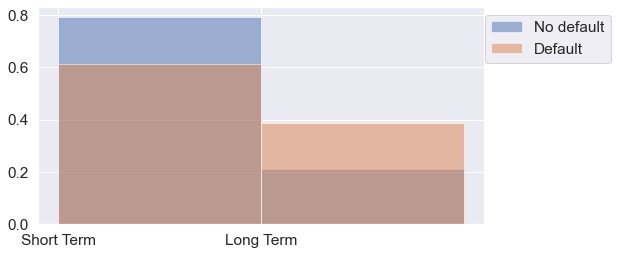

In [57]:
var_name = 'Term'
category_var_target_plot('Term', 2, 3)

In [58]:
distribution_diff(var_name)

Short Term    0.176788
Long Term    -0.176788
Name: Term, dtype: float64

Уровень дефолтов у долгосрочных кредитв существанно выше, чем у краткосрочных.

#### 2. Home Ownership

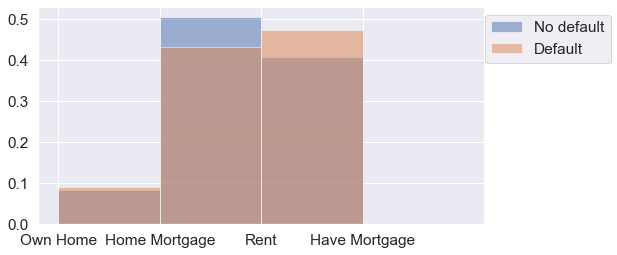

In [59]:
var_name = 'Home Ownership'
category_var_target_plot(var_name, 4, 5)

In [60]:
distribution_diff(var_name)

Have Mortgage    0.000910
Home Mortgage    0.071598
Own Home        -0.006403
Rent            -0.066104
Name: Home Ownership, dtype: float64

У признака Home Ownership уровень дефолта различается только в 2 категриях: Home Morgage и Rent. В модели будем использовать только их.
У Home Morgage уровень дефолта ниже, у Rent - выше

#### 3. Purpose

In [61]:
var_name = 'Purpose'
distribution_diff(var_name)

business loan          -0.012293
buy a car               0.002007
buy house               0.000381
debt consolidation      0.013588
educational expenses    0.001197
home improvements       0.005320
major purchase          0.001495
medical bills          -0.001316
moving                  0.000724
other                  -0.006357
renewable energy             NaN
small business         -0.004398
take a trip             0.000279
vacation                0.000167
wedding                 0.000149
Name: Purpose, dtype: float64

В признаке Purpose уровень дефолта немного различается только в 2 категриях: debt consolidation и business loan. В модели будем использовать только их.
Уровень дефолтов у business loan выше, чем у debt consolidation

#### 4. Years in current job

In [62]:
var_name = 'Years in current job'
distribution_diff(var_name)

10+ years    0.001665
2 years      0.001688
3 years      0.001295
< 1 year    -0.002065
5 years     -0.001384
1 year      -0.001612
4 years     -0.000703
6 years     -0.004146
7 years     -0.000867
8 years      0.001375
9 years      0.004753
Name: Years in current job, dtype: float64

Категории признака Years in current job практически не различаются по уровню дефолтов. В модели использовать не будем.

In [63]:
CATEGORICAL_FEATURE_NAMES.remove(var_name)

#### 5.Tax Liens

In [64]:
var_name = 'Tax Liens'
distribution_diff(var_name)

0.0    0.006752
1.0   -0.000406
2.0   -0.004314
3.0   -0.001438
4.0   -0.000863
5.0   -0.000288
6.0         NaN
7.0         NaN
Name: Tax Liens, dtype: float64

Категории признака Tax Liens практически не различаются по уровню дефолтов. В модели использовать не будем.

In [65]:
CATEGORICAL_FEATURE_NAMES.remove(var_name)

[назад к содержанию](#outline)

### 3.3 Проверка идентичности распределения тренировочного и тестового набора данных

In [66]:
numeric_var = ['Current Loan Amount', 'Credit Score', 'Months since last delinquent',
               'Maximum Open Credit', 'Years of Credit History', 'Number of Open Accounts',
               'Annual Income', 'Monthly Debt']

categorical_var_info = [['Term', 'Short Term', 'Long Term'],
                        ['Purpose', 'debt consolidation', 'business loan'],
                        ['Home Ownership', 'Home Mortgage', 'Rent']]

In [67]:
def compare_distibutions(var_name):
    a1 = df.loc[:, var_name]
    a2 = X_final.loc[:, var_name]
    return ss.ks_2samp(a1.sample(1000), a2.sample(1000))


def comp_categorical_distr(var_name, t1, t2):
    var_and_target_s = df.loc[df[var_name].isin([t1, t2]), [var_name, TARGET_NAME]].sample(1000)
    var_and_target_s.loc[:, 'ID'] = var_and_target_s.index
    table = var_and_target_s.pivot_table(values='ID', index=var_name, columns=TARGET_NAME, aggfunc='count')
    chi2, p, dof, expected = ss.chi2_contingency(table, correction=False)
    return p



def print_unequal_distr_variables(var_list=numeric_var):
    for item in var_list:
        if var_list != numeric_var:
            var_name, t1, t2 = item
        else:
            var_name = item
        p_list = []
        for _ in range(50):
            if var_list == numeric_var:
                _, p = compare_distibutions(var_name)
            else:
                p = comp_categorical_distr(var_name, t1, t2) 
            p_list.append(p)
        p = np.array(p).mean()
        if p < 0.05:
            print(f'Распределение не идентично, p-value={round(p, 2)} \t{var_name}')

### A. Количественные признаки

In [68]:
print_unequal_distr_variables()

### B. Категориальные признаки

In [69]:
print_unequal_distr_variables(categorical_var_info)

Распределение не идентично, p-value=0.0 	Term


[назад к содержанию](#outline)

### 4. Создание групп для Weight of Evidence (WOE) <a name = 'WOE'></a>

Ввиду того, что выборка несбалансированна, будем использовать Weight of Evidence (WOE) признаков.
Признаки группируются на основе анализа данных, проведенного выше.

In [70]:
def WOE_formula(a, epsilon=1e-04):
    a = a.mean()
    if a == 1.0:
        a -= epsilon
    elif a == 0:
        a += epsilon

    return np.log(a / (1 - a))

In [71]:
bin_split_numeric = {}
WOE = {}

### A. Количественные признаки

In [72]:
def WOE_calc_numeric(feature, bin_split):
    feature_dict = {}
    if df[feature].isnull().sum() > 0:
        a = df.loc[df[feature].isnull(), 'Credit Default']
        print(f'n_items bin nan = {len(a)}') 
        feature_dict['nan'] = WOE_formula(a)

    for i in range(1, len(bin_split)):
        cond_1 = df[feature] >= bin_split[i - 1]
        cond_2 = df[feature] < bin_split[i]
        a = df.loc[(cond_1 & cond_2), 'Credit Default']
        print(f'n_items bin {int(bin_split[i])} = {len(a)}') 
        feature_dict[bin_split[i]] = WOE_formula(a)
        
    bin_split_numeric[feature] = bin_split
    WOE[feature] = feature_dict   

#### 1. Annual Income

In [73]:
feature = 'Annual Income'
bin_split = [0, 1.1e+06, 3e+06, 5e+06, 1e+08]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin nan = 1557
n_items bin 1100000 = 2645
n_items bin 3000000 = 3073
n_items bin 5000000 = 181
n_items bin 100000000 = 44

WOE per bin:


{'nan': -0.664382014156811,
 1100000.0: -0.7841714040259439,
 3000000.0: -1.1878264374022938,
 5000000.0: -1.500704712297635,
 100000000.0: -2.3025850929940455}

#### 2. Number of Open Accounts

In [74]:
feature = 'Number of Open Accounts'
bin_split = [0, 9, 13, 9999] #18,
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin 9 = 2415
n_items bin 13 = 2659
n_items bin 9999 = 2426

WOE per bin:


{9: -1.0436025047360038, 13: -0.9286968564142538, 9999: -0.841024560064772}

#### 3. Years of Credit History

In [75]:
feature = 'Years of Credit History'
bin_split = [0, 10, 13, 28, 99]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin 10 = 590
n_items bin 13 = 1037
n_items bin 28 = 5116
n_items bin 99 = 757

WOE per bin:


{10: -0.6829948090959274,
 13: -0.8801180004804297,
 28: -0.9979175364419043,
 99: -0.8104532307553416}

#### 4. Maximum Open Credit

In [76]:
feature = 'Maximum Open Credit'
bin_split = [0, 0.17e+06, 0.6e+06, 0.8e+06, 7e+06, 9e+09] 
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin 170000 = 780
n_items bin 600000 = 3834
n_items bin 800000 = 1043
n_items bin 7000000 = 1813
n_items bin 9000000000 = 30

WOE per bin:


{170000.0: -0.6758888423306645,
 600000.0: -0.8762817755745248,
 800000.0: -0.944651849495853,
 7000000.0: -1.1651789142238673,
 9000000000.0: -9.21024036697585}

#### 5. Months since last delinquent

In [77]:
feature = 'Months since last delinquent'
bin_split = [0, 13, 24, 31, 36, 999]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin nan = 4081
n_items bin 13 = 617
n_items bin 24 = 626
n_items bin 31 = 384
n_items bin 36 = 284
n_items bin 999 = 1508

WOE per bin:


{'nan': -0.9599264632365533,
 13: -0.7645181744518642,
 24: -1.1286574670994975,
 31: -0.7884573603642702,
 36: -1.2755429968271879,
 999: -0.8485612844339757}

#### 6. Current Loan Amount

Из Current Loan Amount выведем значения 99999999 в новый признак No Defaults.

In [78]:
var_name = 'Current Loan Amount'
new_var_name = 'No Defaults'
df.loc[df[var_name] == 99999999, new_var_name] = 1
df.loc[df[var_name] == 99999999, var_name] = np.nan

bin_split = [0, 0.15e+06, 0.25e+06, 0.35e+06, 0.5e+06, 1e+06]
WOE_calc_numeric(var_name, bin_split)
print('\nWOE per bin:')
WOE[var_name]

n_items bin nan = 870
n_items bin 150000 = 1341
n_items bin 250000 = 1654
n_items bin 350000 = 1400
n_items bin 500000 = 1157
n_items bin 1000000 = 1078

WOE per bin:


{'nan': -9.21024036697585,
 150000.0: -0.9351592161785379,
 250000.0: -0.8536397669124878,
 350000.0: -0.747214401830221,
 500000.0: -0.664758177297259,
 1000000.0: -0.5356407928857146}

Категорию nan использовать не будем

In [79]:
del WOE[feature]['nan']

#### 7. Monthly Debt

In [80]:
feature = 'Monthly Debt'
bin_split = [0, 0.06e+05, 0.1e+05, 1e+06]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin 6000 = 794
n_items bin 10000 = 1052
n_items bin 1000000 = 5654

WOE per bin:


{6000.0: -1.1154760947201146,
 10000.0: -0.9996440718624063,
 1000000.0: -0.9002509061931185}

#### 8. Credit Score

Выделим из признака Credit Score признак Default Credit Score

In [81]:
var_name = 'Credit Score'
new_var_name = 'Default Credit Score'
df.loc[df[var_name].isnull(), var_name] = 580
df.loc[df[var_name] > 1000, new_var_name] = 1
df.loc[df[var_name] > 1000, var_name] = np.nan

bin_split = [0, 584, 710, 730, 742, 755]
WOE_calc_numeric(var_name, bin_split)
print('\nWOE per bin:')
WOE[var_name]

n_items bin nan = 400
n_items bin 584 = 1557
n_items bin 710 = 1410
n_items bin 730 = 1377
n_items bin 742 = 1473
n_items bin 755 = 1283

WOE per bin:


{'nan': 9.21024036697596,
 584: -0.664382014156811,
 710: -0.7773392717802932,
 730: -1.1665852722543157,
 742: -1.485107755783986,
 755: -2.091776499837787}

Категорию nan использовать не будем

In [82]:
del WOE[var_name]['nan']

#### 9. Monthly Debt cover

In [83]:
feature = 'Monthly Debt cover'
bin_split = [30, 55, 75, 150, 300, 17125]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin nan = 1785
n_items bin 55 = 1669
n_items bin 75 = 1467
n_items bin 150 = 1855
n_items bin 300 = 539
n_items bin 17125 = 185

WOE per bin:


{'nan': -0.7671920512780886,
 55: -0.6645226859851078,
 75: -0.9538131711972447,
 150: -1.2011716820462242,
 300: -1.3270515275570298,
 17125: -1.642227735257091}

Категорию nan использовать не будем

In [84]:
del WOE[feature]['nan']

#### 10. Months till Credit Balance repayment

In [85]:
feature = 'Months till Credit Balance repayment'
bin_split = [0, 12, 36, 67, 503]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin nan = 6
n_items bin 12 = 3039
n_items bin 36 = 3798
n_items bin 67 = 583
n_items bin 503 = 74

WOE per bin:


{'nan': -1.6094379124341005,
 12: -0.8767743423141448,
 36: -0.9437303473823053,
 67: -1.0601024339062342,
 503: -2.624668592163159}

Категория nan малочисленна, удалим ее.

In [86]:
del WOE[feature]['nan']

### B. Категориальные признаки

In [87]:
def calc_a(sub_category):    
    cond = df[feature] == sub_category[0]
    for j in range(1, len(sub_category)):
        cond |= (df[feature] == sub_category[j])        
    a = df.loc[cond, 'Credit Default']    
    return a

def WOE_calc(feature, category_list):
    feature_dict = {}
    if df[feature].isnull().sum() > 0:
        a = df.loc[df[feature].isnull(), 'Credit Default']
        print(f'n_items category nan = {len(a)}')

        feature_dict['nan'] = WOE_formula(a)
    
    for i in range(len(category_list)):
        if isinstance(category_list[i], list):
            a = calc_a(category_list[i])
        else:
            a = df.loc[df[feature] == category_list[i], 'Credit Default']
        print(f'{len(a)}\t{category_list[i]}')
        WOE_ = WOE_formula(a)       
        
        if isinstance(category_list[i], list):
            for category in category_list[i]:
                feature_dict[category] = WOE_
        else:
            feature_dict[category_list[i]] = WOE_
            
    bin_split_categorical[feature] = category_list
    WOE[feature] = feature_dict    

In [88]:
bin_split_categorical = {}

#### 1. Home Ownership

In [89]:
feature = 'Home Ownership'
df[feature].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Категории 'Own Home' и 'Have Mortgage' не влияют на уровень дефолта по кредитам, поэтому использовать их не будем

In [90]:
category_list = ['Home Mortgage', 'Rent']
WOE_calc(feature, category_list)
print('\nWOE per category:')
WOE[feature]

3637	Home Mortgage
3204	Rent

WOE per category:


{'Home Mortgage': -1.0887383741091161, 'Rent': -0.7859162935645262}

#### 2. Purpose

In [91]:
feature = 'Purpose'
df[feature].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

Будем использовать только категории, различающиеся по уровню дефолтов: debt consolidation и business loan

In [92]:
category_list = ['debt consolidation', 'business loan']
WOE_calc(feature, category_list)
print('\nWOE per category:')
WOE[feature]

5944	debt consolidation
129	business loan

WOE per category:


{'debt consolidation': -0.9530901363384262,
 'business loan': -0.2967319079716989}

#### 3. Term

In [93]:
feature = 'Term'
df[feature].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [94]:
category_list = ['Short Term', 'Long Term']
WOE_calc(feature, category_list)
print('\nWOE per category:')
WOE[feature]

5556	Short Term
1944	Long Term

WOE per category:


{'Short Term': -1.1889804856067696, 'Long Term': -0.3237870770938973}

[назад к содержанию](#outline)

### 5. Feature Engineering  <a name = 'feature_engineering'></a>

In [95]:
class FeatureGenerator:
    def __init__(self, bin_split_numeric, bin_split_categorical, 
                 NUMERIC_FEATURE_NAMES,
                 NEW_NUMERIC_FEATURE_NAMES,
                 CATEGORICAL_FEATURE_NAMES):
        self.bin_split_numeric = bin_split_numeric
        self.bin_split_categorical = bin_split_categorical
        self.NUMERIC_FEATURE_NAMES = NUMERIC_FEATURE_NAMES
        self.NEW_NUMERIC_FEATURE_NAMES = NEW_NUMERIC_FEATURE_NAMES
        self.CATEGORICAL_FEATURE_NAMES = CATEGORICAL_FEATURE_NAMES
        
        
    def WOE_formula(self, a, epsilon=1e-04):
        a = a.mean()
        if a == 1.0:
            a -= epsilon
        elif a == 0:
            a += epsilon
            
        return np.log(a / (1 - a))
    
        
    def WOE_calc_numeric(self, feature):
        feature_dict = {}
        if (df[feature].isnull().sum() > 0):
            a = df.loc[df[feature].isnull(), 'Credit Default']
            feature_dict['nan'] = self.WOE_formula(a)

        for i in range(1, len(self.bin_split_numeric[feature])):
            cond_1 = df[feature] >= self.bin_split_numeric[feature][i - 1]
            cond_2 = df[feature] < self.bin_split_numeric[feature][i]
            a = df.loc[(cond_1 & cond_2), 'Credit Default']            

            feature_dict[self.bin_split_numeric[feature][i]] = self.WOE_formula(a) 

        return feature_dict
    
    
    def calc_a(self, feature, sub_category):    
        cond = df[feature] == sub_category[0]
        for j in range(1, len(sub_category)):
            cond |= (df[feature] == sub_category[j]) 
            
        a = df.loc[cond, 'Credit Default']
        
        return a
    
    
    def WOE_calc_categorical(self, feature):
        feature_dict = {}
        if df[feature].isnull().sum() > 0:
            a = df.loc[df[feature].isnull(), 'Credit Default'] 
            feature_dict['nan'] = self.WOE_formula(a)

        for i in range(len(self.bin_split_categorical[feature])):
            sub_category = self.bin_split_categorical[feature][i]
            if isinstance(sub_category, list):                
                a = self.calc_a(feature, sub_category)                
            else:
                a = df.loc[df[feature] == sub_category, 'Credit Default']  
            WOE_ = self.WOE_formula(a)            

            if isinstance(sub_category, list):                
                for item in sub_category:                    
                    feature_dict[item] = WOE_
            else:
                feature_dict[sub_category] = WOE_
        
        return feature_dict    
    
    
    def new_features(self, df):
        # Credit Score
        var_name = 'Credit Score'
        new_var_name = 'Default Credit Score'        
        df.loc[df[var_name] > 1000, new_var_name] = 1
        
        df.loc[df[var_name].isnull(), var_name] = 580 
        df.loc[df[var_name] > 1000, var_name] = np.nan
        
        # Current Loan Amount
        var_name = 'Current Loan Amount'
        new_var_name = 'No Defaults'
        df.loc[df[var_name] == 99999999, new_var_name] = 1
        df.loc[df[var_name] == 99999999, var_name] = np.nan
        
        #'Monthly Debt cover'
        var_name = self.NEW_NUMERIC_FEATURE_NAMES[0]   
        cond_1 = (df['Annual Income'] < 3e+06) & (df['Monthly Debt'] > 0)
        df.loc[:, var_name] = df.loc[cond_1, 'Annual Income'] / df.loc[cond_1, 'Monthly Debt'] 
        
        #'Months till Credit Balance repayment'
        var_name = self.NEW_NUMERIC_FEATURE_NAMES[1]   
        df.loc[:, var_name] = df['Current Credit Balance'] / df['Monthly Debt']
        
        return df
        
    
    def fit(self, X, y=None):
        df = X.copy()
        df = self.new_features(df)
        
        if y is not None:
            df['Credit Default'] = y.values 
            
            self.WOE = {}
            for feature in self.NUMERIC_FEATURE_NAMES + self.NEW_NUMERIC_FEATURE_NAMES:
                self.WOE[feature] = self.WOE_calc_numeric(feature)
            
                
            for feature in self.CATEGORICAL_FEATURE_NAMES:
                self.WOE[feature] = self.WOE_calc_categorical(feature)  

    
    def transform(self, X):
        X = self.new_features(X)       
        
        for feature in self.NUMERIC_FEATURE_NAMES + self.NEW_NUMERIC_FEATURE_NAMES:
            new_feature = feature + '_'        
            if (X[feature].isnull().sum() > 0) and (feature not in ['Credit Score', 'Current Loan Amount']):
                X.loc[X[feature].isnull(), new_feature] = self.WOE[feature]['nan']            
            
            feature_list = self.bin_split_numeric[feature]
            for i in range(1, len(feature_list)):
                cond_1 = X[feature] >= feature_list[i - 1]
                cond_2 = X[feature] < feature_list[i]
                X.loc[(cond_1 & cond_2), new_feature] = self.WOE[feature][feature_list[i]]
        

        for feature in self.CATEGORICAL_FEATURE_NAMES:
            new_feature = feature + '_'
            if X[feature].isnull().sum() > 0:
                X.loc[X[feature].isnull(), new_feature] = self.WOE[feature]['nan']
                
            feature_list = self.WOE[feature]
            for item in feature_list:        
                X.loc[X[feature] == item, new_feature] = self.WOE[feature][item]               
        
       
        return X.fillna(0)

### 6. Tain_test_split <a name = 'tain_test_split'></a>

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    stratify = y,
                                                    test_size=0.2)

### 7. Генерация признаков <a name = 'feature_generation'></a>

#### 1. Обучающий датасет

In [97]:
features = FeatureGenerator(bin_split_numeric, bin_split_categorical, 
                            NUMERIC_FEATURE_NAMES, 
                            NEW_NUMERIC_FEATURE_NAMES, 
                            CATEGORICAL_FEATURE_NAMES)
features.fit(X_train, y_train)
X_train = features.transform(X_train)
X_test = features.transform(X_test)

#### 2. Тестовый датасет

In [98]:
features = FeatureGenerator(bin_split_numeric, bin_split_categorical,
                            NUMERIC_FEATURE_NAMES, 
                            NEW_NUMERIC_FEATURE_NAMES,
                            CATEGORICAL_FEATURE_NAMES)
features.fit(X, y)
X = features.transform(X)
X_final = features.transform(X_final)

### 8. Балансировка классов <a name = 'class_balancing'></a>

In [99]:
ros = RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_train_ros))

Original dataset shape Counter({0: 4310, 1: 1690})
Resample dataset shape Counter({0: 4310, 1: 4310})


### 9. Отбор признаков <a name = 'feature_selection'></a>

In [100]:
SELECTED_FEATURE_NAMES = ['Number of Open Accounts_','Years of Credit History_', 
                          'Maximum Open Credit_',                           
                          'Current Loan Amount_', 'Monthly Debt_', 
                          'Credit Score_', 'Months since last delinquent_','Annual Income_',
                          
                          'Default Credit Score', 'No Defaults',
                          'Monthly Debt cover_', 'Months till Credit Balance repayment_',
                          
                          #'Term_', 
                          'Home Ownership_', 'Purpose_']

Распределение признака Term на обучающем и тестовом датасетах не идентично, соответственно, производная от этого признака исключается из модели.

[назад к содержанию](#outline)

### 10. Модель <a name = 'model'></a>

Калибровка модели

In [101]:
def calibration(clf, X_train, y_train, X_test, method, split_level):
    model = CalibratedClassifierCV(clf, method=method, cv='prefit')
    model.fit(X_train, y_train)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]
    
    y_train_pred = np.zeros(y_train_pred_proba.shape)
    y_test_pred = np.zeros(y_test_pred_proba.shape)
    
    y_train_pred[y_train_pred_proba > split_level] = 1
    y_test_pred[y_test_pred_proba > split_level] = 1
    
    return y_train_pred, y_test_pred

Для получения более надежной оценки результатов работы модели на кросс-валидации используется RepeatedStratifiedKFold.

In [102]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

def cv_f1_score(model, calibrate=False, method='sigmoid', split_level=0.5):    
    f1_score_list = []
    for train_index, test_index in kfold.split(X, y):
        X_train_cv, X_test_cv = X.loc[train_index, :], X.loc[test_index, :]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
        
        features = FeatureGenerator(bin_split_numeric, bin_split_categorical,
                                    NUMERIC_FEATURE_NAMES,
                                    NEW_NUMERIC_FEATURE_NAMES,
                                    CATEGORICAL_FEATURE_NAMES)
        features.fit(X_train_cv, y_train_cv)
        X_train_cv = features.transform(X_train_cv)
        X_test_cv = features.transform(X_test_cv)
        
        X_train_ros_cv, y_train_ros_cv = ros.fit_resample(X_train_cv, y_train_cv)
        
        if calibrate:        
            y_train_pred_cv, y_test_pred_cv = calibration(model, 
                                                          X_train_ros_cv[SELECTED_FEATURE_NAMES], 
                                                          y_train_ros_cv, 
                                                          X_test_cv[SELECTED_FEATURE_NAMES],
                                                          method, split_level)
        else:
            model.fit(X_train_ros_cv[SELECTED_FEATURE_NAMES], y_train_ros_cv)
            y_train_pred_cv = model.predict(X_train_ros_cv[SELECTED_FEATURE_NAMES])
            y_test_pred_cv = model.predict(X_test_cv[SELECTED_FEATURE_NAMES])
            
        f1_score_list.append(f1_score(y_test_cv, y_test_pred_cv, average=None)[1])
    
    f1_score_mean = round(np.array(f1_score_list).mean(), 4)
    f1_score_std = round(np.array(f1_score_list).std(), 4)
    print(f'cross_validation_f1_score = {f1_score_mean} +- {f1_score_std}\n')

In [103]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('roc_auc_score =', roc_auc_score(y_train_true, y_train_pred), '\n')
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('roc_auc_score =', roc_auc_score(y_test_true, y_test_pred), '\n')
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred)) 

In [104]:
def choose_calibration(clf):
    # no calibration    
    sw_train = np.random.rand(y_train_ros.shape[0])
    sw_test = np.random.rand(y_test.shape[0])    
    prob_pos_clf = clf.predict_proba(X_test[SELECTED_FEATURE_NAMES])[:, 1]

    # with isotonic calibration
    clf_isotonic = CalibratedClassifierCV(clf, cv=3, method='isotonic')
    clf_isotonic.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros, sample_weight=sw_train)
    prob_pos_isotonic = clf_isotonic.predict_proba(X_test[SELECTED_FEATURE_NAMES])[:, 1]

    # with sigmoid calibration
    clf_sigmoid = CalibratedClassifierCV(clf, cv=3, method='sigmoid')
    clf_sigmoid.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros, sample_weight=sw_train)
    prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test[SELECTED_FEATURE_NAMES])[:, 1]

    print("Brier scores: (the smaller the better)")

    clf_score = brier_score_loss(y_test, prob_pos_clf, sample_weight=sw_test)
    print("No calibration: %1.3f" % clf_score)

    clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic, sample_weight=sw_test)
    print("With isotonic calibration: %1.3f" % clf_isotonic_score)

    clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid, sample_weight=sw_test)
    print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)

In [105]:
def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1.)

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        
        clf.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)
        y_pred = clf.predict(X_test[SELECTED_FEATURE_NAMES])
        
        
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test[SELECTED_FEATURE_NAMES])[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test[SELECTED_FEATURE_NAMES])
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

#### 1. LogisticRegression

In [106]:
model_lr = LogisticRegression(solver='saga',
                              penalty='elasticnet',
                              l1_ratio=0.2                              
                             )

model_lr.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)
choose_calibration(model_lr)

Brier scores: (the smaller the better)
No calibration: 0.198
With isotonic calibration: 0.199
With sigmoid calibration: 0.201


У модели без калибровки Brier scores ниже, чем у моделей с калибровкой. Калибровку делать не будем

In [107]:
y_train_pred = model_lr.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model_lr.predict(X_test[SELECTED_FEATURE_NAMES])

cv_f1_score(model_lr)
get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

#cross_validation_f1_score = 0.5256 +- 0.0103

cross_validation_f1_score = 0.5256 +- 0.0103

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.66      0.67      4310
           1       0.67      0.68      0.68      4310

    accuracy                           0.67      8620
   macro avg       0.67      0.67      0.67      8620
weighted avg       0.67      0.67      0.67      8620

roc_auc_score = 0.6718097447795823 

TEST

              precision    recall  f1-score   support

           0       0.82      0.62      0.71      1077
           1       0.40      0.65      0.50       423

    accuracy                           0.63      1500
   macro avg       0.61      0.64      0.60      1500
weighted avg       0.70      0.63      0.65      1500

roc_auc_score = 0.638472378619359 

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               670  407
1               146  277


#### 2. SVM

In [108]:
model_svm = svm.SVC(kernel='linear', probability=True)
model_svm.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)

choose_calibration(model_svm)

Brier scores: (the smaller the better)
No calibration: 0.212
With isotonic calibration: 0.203
With sigmoid calibration: 0.211


У модели с isotonic calibration Brier scores немного ниже, чем у моделей без калибовки и с sigmoid calibration. Но разница незначительна, калибровку делать не будем.

In [109]:
y_train_pred = model_svm.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model_svm.predict(X_test[SELECTED_FEATURE_NAMES])

cv_f1_score(model_svm)
get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

#F1 > 0.5
#cross_validation_f1_score = 0.5262 +- 0.0135

cross_validation_f1_score = 0.5262 +- 0.0135

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.63      0.66      4310
           1       0.66      0.70      0.68      4310

    accuracy                           0.67      8620
   macro avg       0.67      0.67      0.67      8620
weighted avg       0.67      0.67      0.67      8620

roc_auc_score = 0.668445475638051 

TEST

              precision    recall  f1-score   support

           0       0.83      0.60      0.70      1077
           1       0.40      0.68      0.51       423

    accuracy                           0.63      1500
   macro avg       0.62      0.64      0.60      1500
weighted avg       0.71      0.63      0.64      1500

roc_auc_score = 0.6421896916177721 

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               650  427
1               135  288


#### 3. RandomForestClassifier

Баланс классов целевой переменной дополнительно смещен в пользу объектов с дефолтами по кредитам.

In [110]:
w = 1.1 # The weight for the positive class
model_rf = RandomForestClassifier(n_estimators=35,  
                                  max_depth=8,                                  
                                  min_samples_leaf=1,
                                  class_weight={0: 1, 1: w},
                                  )

model_rf.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)
choose_calibration(model_rf)

Brier scores: (the smaller the better)
No calibration: 0.208
With isotonic calibration: 0.199
With sigmoid calibration: 0.202


У модели без калибровки и моделей с калибровкой Brier scores отличается незначительно, калибровку делать не будем

In [111]:
y_train_pred = model_rf.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model_rf.predict(X_test[SELECTED_FEATURE_NAMES])

cv_f1_score(model_rf)
get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

#cross_validation_f1_score = 0.5184 +- 0.0126

cross_validation_f1_score = 0.5184 +- 0.0126

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.64      0.69      4310
           1       0.69      0.79      0.74      4310

    accuracy                           0.72      8620
   macro avg       0.72      0.72      0.71      8620
weighted avg       0.72      0.72      0.71      8620

roc_auc_score = 0.716125290023202 

TEST

              precision    recall  f1-score   support

           0       0.83      0.59      0.69      1077
           1       0.40      0.70      0.51       423

    accuracy                           0.62      1500
   macro avg       0.62      0.64      0.60      1500
weighted avg       0.71      0.62      0.64      1500

roc_auc_score = 0.6432894104321829 

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               632  445
1               127  296


#### 4. XGBClassifier

In [112]:
param_dist = {'objective':'binary:logistic', 'n_estimators':20}
model_xgb = XGBClassifier(**param_dist)
model_xgb.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)

choose_calibration(model_xgb)

Brier scores: (the smaller the better)
No calibration: 0.202
With isotonic calibration: 0.200
With sigmoid calibration: 0.204


У модели без калибровки и моделей с калибровкой Brier scores практически не отличается, калибровку делать не будем

In [113]:
y_train_pred = model_xgb.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model_xgb.predict(X_test[SELECTED_FEATURE_NAMES])

cv_f1_score(model_xgb)
get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

#F1 > 0.5
#cross_validation_f1_score = 0.523 +- 0.0125

cross_validation_f1_score = 0.523 +- 0.0125

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.70      0.72      4310
           1       0.71      0.75      0.73      4310

    accuracy                           0.72      8620
   macro avg       0.72      0.72      0.72      8620
weighted avg       0.72      0.72      0.72      8620

roc_auc_score = 0.7240139211136891 

TEST

              precision    recall  f1-score   support

           0       0.82      0.64      0.72      1077
           1       0.41      0.65      0.51       423

    accuracy                           0.64      1500
   macro avg       0.62      0.64      0.61      1500
weighted avg       0.71      0.64      0.66      1500

roc_auc_score = 0.6440006058331194 

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               687  390
1               148  275


#### 5. AdaBoostClassifier

In [114]:
model_ab = AdaBoostClassifier(n_estimators=50, 
                              learning_rate = 0.65
                             )
model_ab.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)
choose_calibration(model_ab)

Brier scores: (the smaller the better)
No calibration: 0.228
With isotonic calibration: 0.200
With sigmoid calibration: 0.199


Brier scores калиброванной модели ниже, чем у некалиброванной. Построим графикики некалиброванной и калиброванных моделей. В качестве базовой модели используется логистическая регрессия

Logistic:
	Brier: 0.202
	Precision: 0.403
	Recall: 0.652
	F1: 0.498

ab:
	Brier: 0.227
	Precision: 0.401
	Recall: 0.674
	F1: 0.503

ab + Isotonic:
	Brier: 0.201
	Precision: 0.411
	Recall: 0.669
	F1: 0.509

ab + Sigmoid:
	Brier: 0.200
	Precision: 0.412
	Recall: 0.678
	F1: 0.513



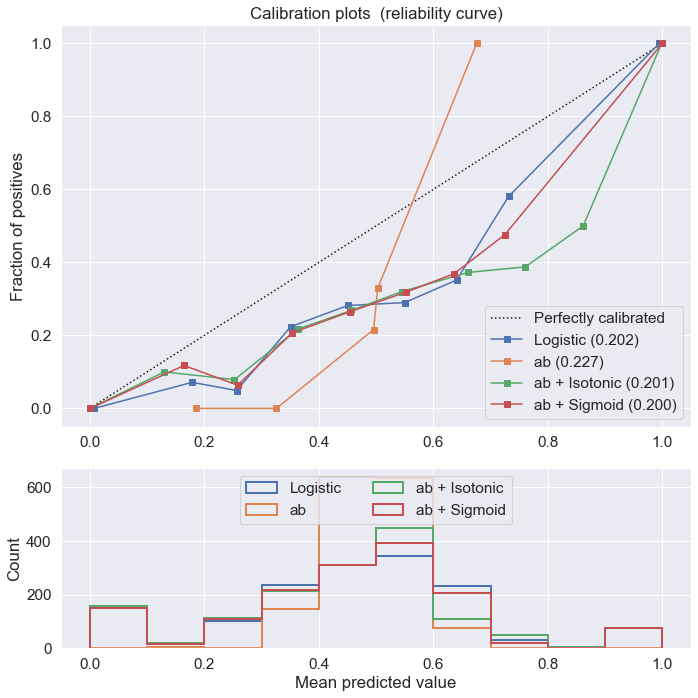

In [115]:
plot_calibration_curve(model_ab, "ab", 1)
plt.show()

In [116]:
method ='sigmoid'
split_level = 0.52

print('Без калибровки:') 
cv_f1_score(model_ab)
print('С калибровкой:')
cv_f1_score(model_ab, calibrate=True, method=method, split_level=split_level)
      
y_train_pred, y_test_pred = calibration(model_ab, 
                                        X_train_ros[SELECTED_FEATURE_NAMES], 
                                        y_train_ros, 
                                        X_test[SELECTED_FEATURE_NAMES],
                                        method=method, split_level=split_level)

get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

Без калибровки:
cross_validation_f1_score = 0.5307 +- 0.0141

С калибровкой:
cross_validation_f1_score = 0.5361 +- 0.0163

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      4310
           1       0.68      0.68      0.68      4310

    accuracy                           0.68      8620
   macro avg       0.68      0.68      0.68      8620
weighted avg       0.68      0.68      0.68      8620

roc_auc_score = 0.6809744779582367 

TEST

              precision    recall  f1-score   support

           0       0.82      0.64      0.72      1077
           1       0.42      0.65      0.51       423

    accuracy                           0.64      1500
   macro avg       0.62      0.65      0.61      1500
weighted avg       0.71      0.64      0.66      1500

roc_auc_score = 0.6458576160466755 

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0               691  386
1               148  275


#### 6. VotingClassifier

VotingClassifier - ансамбль моделей без калибровки (включая AdaBoostClassifier)

In [117]:
model = VotingClassifier(estimators=[('lr', model_lr), ('svm', model_svm), 
                                     ('rf', model_rf), ('xgb', model_xgb), 
                                     ('ab', model_ab)], voting='hard')
model = model.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)

y_train_pred = model.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model.predict(X_test[SELECTED_FEATURE_NAMES])

cv_f1_score(model)
get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

#cross_validation_f1_score = 0.5269 +- 0.0123

cross_validation_f1_score = 0.5269 +- 0.0123

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.65      0.67      4310
           1       0.67      0.73      0.70      4310

    accuracy                           0.69      8620
   macro avg       0.69      0.69      0.69      8620
weighted avg       0.69      0.69      0.69      8620

roc_auc_score = 0.6870069605568445 

TEST

              precision    recall  f1-score   support

           0       0.83      0.60      0.69      1077
           1       0.40      0.68      0.50       423

    accuracy                           0.62      1500
   macro avg       0.61      0.64      0.60      1500
weighted avg       0.71      0.62      0.64      1500

roc_auc_score = 0.6386863957539002 

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               645  432
1               136  287


[назад к содержанию](#outline)

### 11. Интерпретация результатов <a name = 'results_interpretation'></a>

* Наиболее значимыми признаками являются 'Credit Score_' и 'Current Loan Amount_'.
* Значимость остальных признаков модели оценивают по-разному.
* VotingClassifier объединяет 5 моделей без колибровки: LogisticRegression, SVM, RandomForestClassifier, XGBClassifier, AdaBoostClassifier. На данном датасете f1-score AdaBoostClassifier выше, а откалиброванная версия AdaBoostClassifier работает еще лучше, поэтому она выбрана для финанльной модели.

#### ExtraTreesClassifier

Feature ranking:
1. feature 3 (0.136052)
2. feature 6 (0.108441)
3. feature 5 (0.105381)
4. feature 2 (0.085910)
5. feature 8 (0.076957)
6. feature 12 (0.069769)
7. feature 11 (0.068682)
8. feature 1 (0.067588)
9. feature 0 (0.066573)
10. feature 10 (0.059350)
11. feature 9 (0.049821)
12. feature 13 (0.036149)
13. feature 7 (0.035216)
14. feature 4 (0.034110)


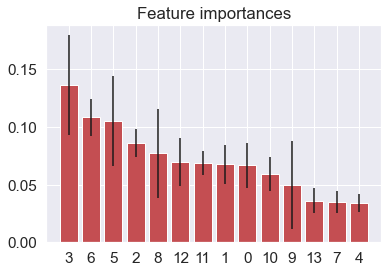

In [118]:
X = X.fillna(0)
forest = ExtraTreesClassifier(n_estimators=100,
                              random_state=0)

forest.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

f_list = []
for f in range(X_train_ros[SELECTED_FEATURE_NAMES].shape[1]):
    f_list.append(indices[f])
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_ros[SELECTED_FEATURE_NAMES].shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X_train_ros[SELECTED_FEATURE_NAMES].shape[1]])
plt.show()

In [119]:
list(X_train_ros[SELECTED_FEATURE_NAMES].columns[f_list])

['Current Loan Amount_',
 'Months since last delinquent_',
 'Credit Score_',
 'Maximum Open Credit_',
 'Default Credit Score',
 'Home Ownership_',
 'Months till Credit Balance repayment_',
 'Years of Credit History_',
 'Number of Open Accounts_',
 'Monthly Debt cover_',
 'No Defaults',
 'Purpose_',
 'Annual Income_',
 'Monthly Debt_']

####  RandomForestClassifier

In [120]:
feature_importances = pd.DataFrame(zip(X_train_ros[SELECTED_FEATURE_NAMES].columns,
                                       model_rf.feature_importances_ / model_rf.feature_importances_.sum()), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
8,Default Credit Score,0.241539
5,Credit Score_,0.213577
9,No Defaults,0.208902
3,Current Loan Amount_,0.081452
10,Monthly Debt cover_,0.053442
7,Annual Income_,0.041145
2,Maximum Open Credit_,0.029229
12,Home Ownership_,0.024969
6,Months since last delinquent_,0.024192
0,Number of Open Accounts_,0.020212


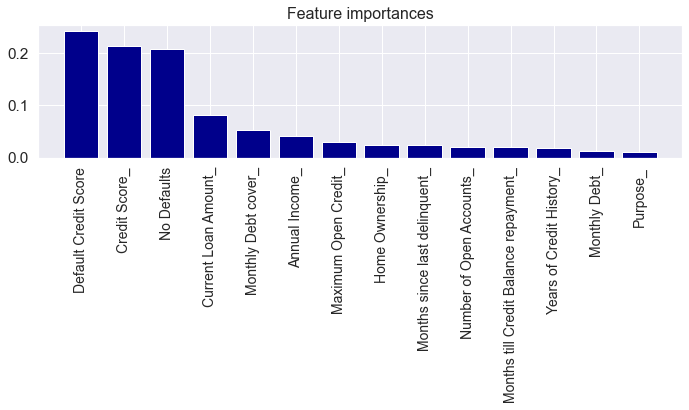

In [121]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (10, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()    
    plt.show()
    
plot_feature_importances(importances = model_rf.feature_importances_, X=X_train_ros[SELECTED_FEATURE_NAMES])

[назад к содержанию](#outline)

## II. Прогнозирование на тестовом датасете <a name = 'forecasting'></a>

#### Балансировка классов

In [122]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 5387, 1: 2113})
Resample dataset shape Counter({0: 5387, 1: 5387})


#### Обучение модели на полном наборе данных

In [123]:
model = CalibratedClassifierCV(model_ab.fit(X_ros[SELECTED_FEATURE_NAMES], y_ros), 
                               method='sigmoid', cv='prefit')
model.fit(X_ros[SELECTED_FEATURE_NAMES], y_ros)

CalibratedClassifierCV(base_estimator=AdaBoostClassifier(learning_rate=0.65),
                       cv='prefit')

#### Прогнозирование целевой переменной

In [124]:
y_pred_proba = model.predict_proba(X_final[SELECTED_FEATURE_NAMES])[:, 1]
y_pred = np.zeros(y_pred_proba.shape)

split_level=0.52
y_pred[y_pred_proba > split_level] = 1

In [125]:
y_final=pd.DataFrame(y_pred, columns=[TARGET_NAME])
y_final = y_final.astype('int8')
y_final.to_csv(PATH + 'YKutovaya_predictions.csv')
y_final.head()

,Credit Default
0,1
1,1
2,1
3,0
4,1


In [126]:
y_final[TARGET_NAME].value_counts()

0    1414
1    1086
Name: Credit Default, dtype: int64

[назад к содержанию](#outline)